In [ ]:
# Add the directory containing api_connection.py to the system path
import sys
import os
from pathlib import Path
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, Session, SamplerV2 as Sampler
from qiskit.visualization import plot_histogram
sys.path.append(str(Path.cwd() / "bachelor_thesis"))
from api_connection import QiskitService
from qiskit_aer import AerSimulator  # For simulation comparison

# Load the IBM Quantum Runtime service


#backend = AerProvider().get_backend("qasm_simulator")
backend = QiskitService(str(Path.cwd() / ".env")).get_least_busy_backend()


Connected to IBM Quantum.


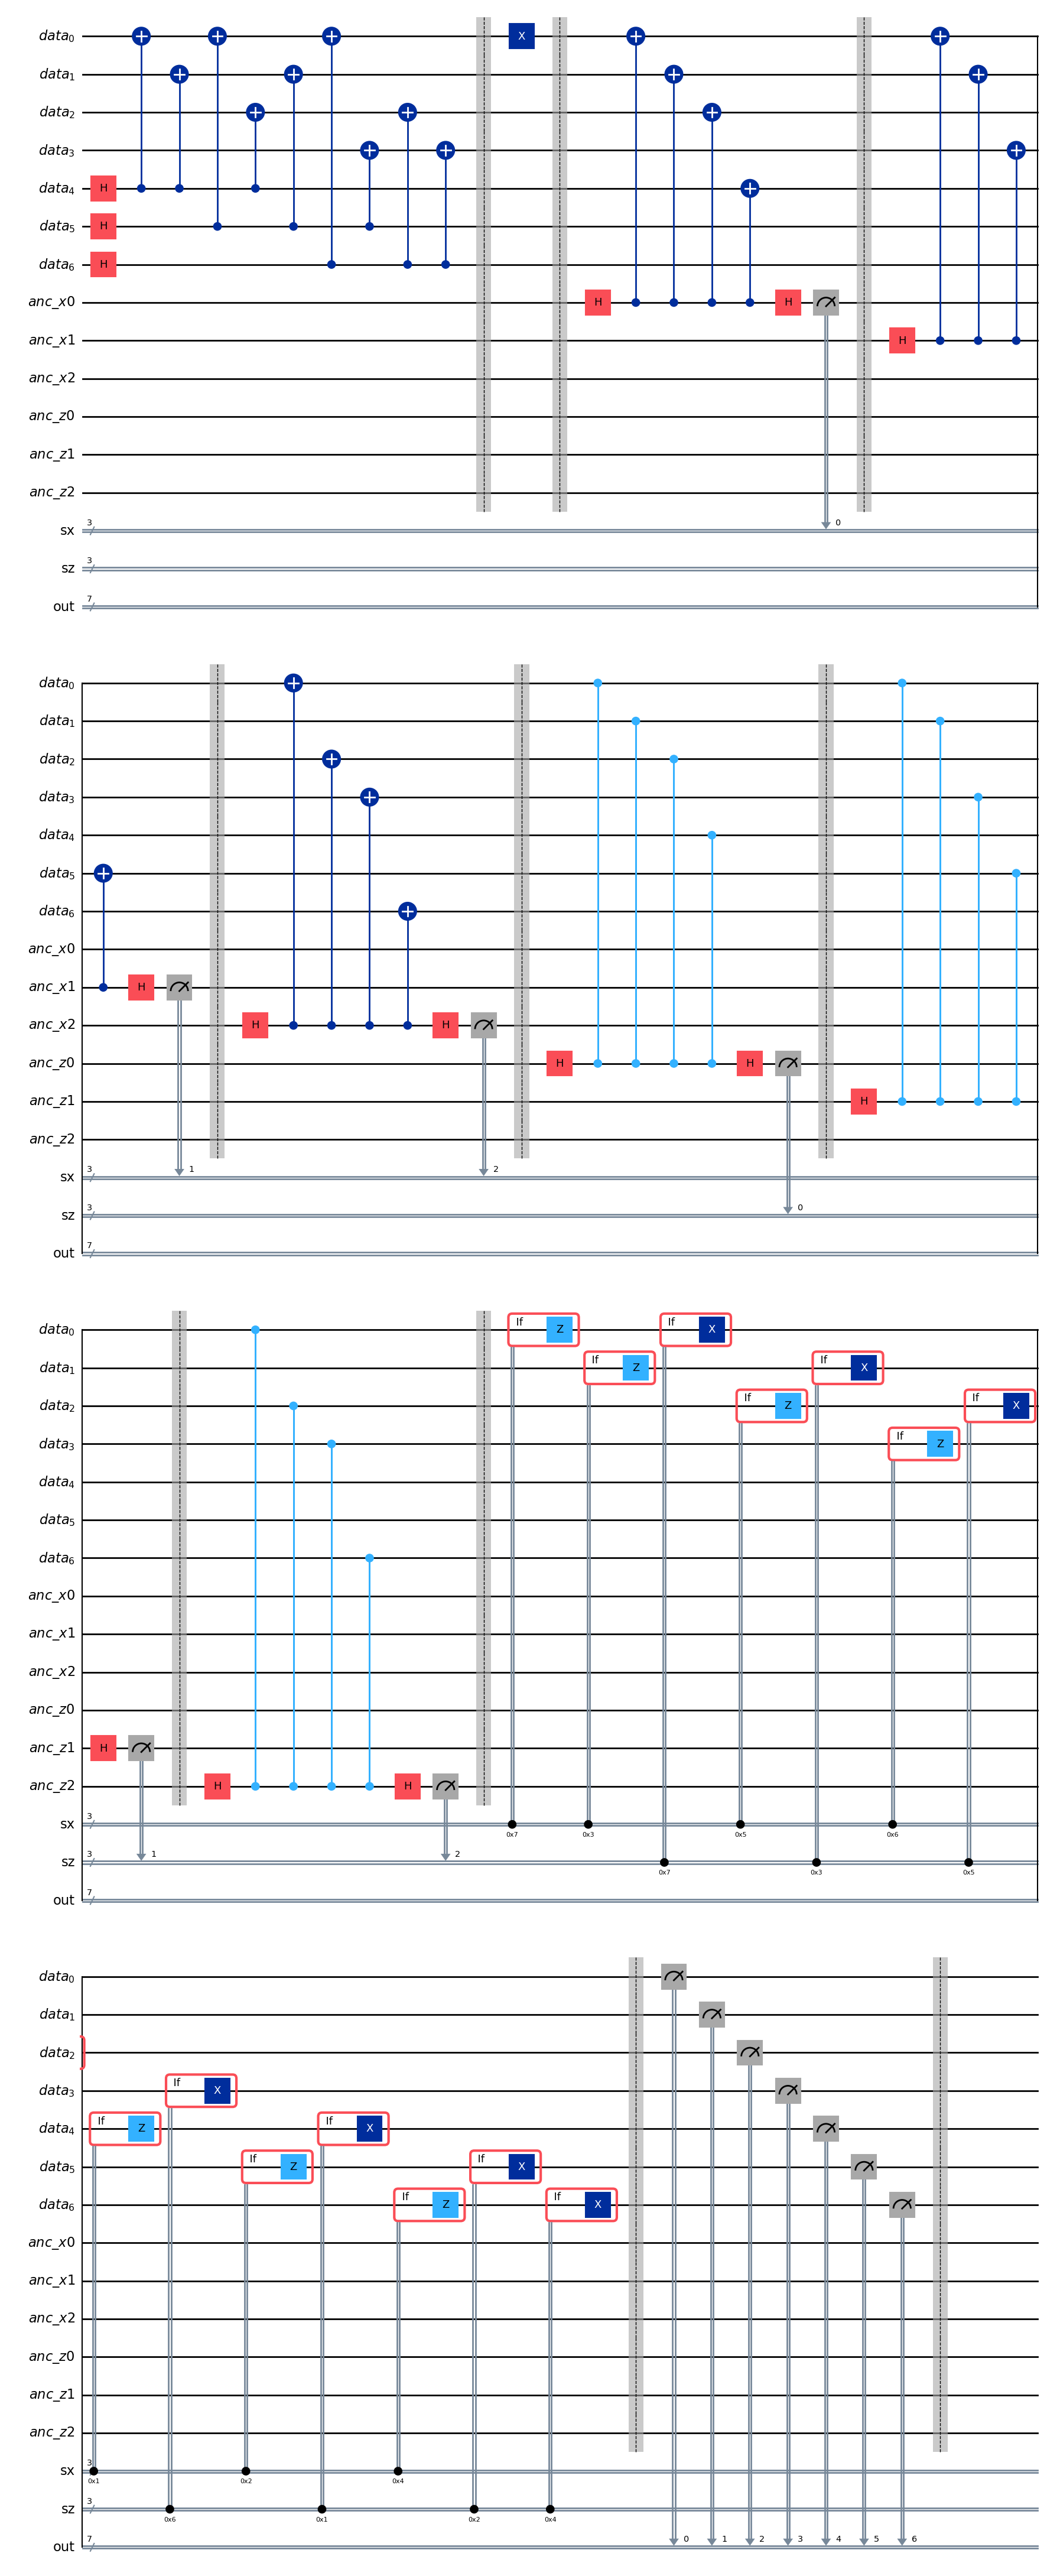

In [ ]:
# Define quantum and classical registers
data = QuantumRegister(7, 'data')          # 7 data qubits for the encoded state
ancilla_x0 = QuantumRegister(1, 'anc_x0')  # Ancilla for X stabilizer 1
ancilla_x1 = QuantumRegister(1, 'anc_x1')  # Ancilla for X stabilizer 2
ancilla_x2 = QuantumRegister(1, 'anc_x2')  # Ancilla for X stabilizer 3
ancilla_z0 = QuantumRegister(1, 'anc_z0')  # Ancilla for Z stabilizer 1
ancilla_z1 = QuantumRegister(1, 'anc_z1')  # Ancilla for Z stabilizer 2
ancilla_z2 = QuantumRegister(1, 'anc_z2')  # Ancilla for Z stabilizer 3
syndrome_x = ClassicalRegister(3, 'sx')    # 3 bits for X syndromes
syndrome_z = ClassicalRegister(3, 'sz')    # 3 bits for Z syndromes
logical_out = ClassicalRegister(7, 'out')  # Changed to 7 bits to match classical version

# Initialize the quantum circuit
circuit = QuantumCircuit(data, ancilla_x0, ancilla_x1, ancilla_x2, ancilla_z0, ancilla_z1, ancilla_z2, syndrome_x, syndrome_z, logical_out)

# Step 1: Encode the logical |0_L⟩ state
circuit.h(data[4])
circuit.h(data[5])
circuit.h(data[6])
circuit.cx(data[4], data[0])
circuit.cx(data[4], data[1])
circuit.cx(data[4], data[2])
circuit.cx(data[5], data[0])
circuit.cx(data[5], data[1])
circuit.cx(data[5], data[3])
circuit.cx(data[6], data[0])
circuit.cx(data[6], data[2])
circuit.cx(data[6], data[3])
circuit.barrier()

# Step 2: Introduce an error (for testing)
circuit.x(data[0])  # X error on qubit 0
circuit.barrier()

# Step 3: Measure X stabilizers (detect Z errors)
# X Stabilizer 1: X0 X1 X2 X4
circuit.h(ancilla_x0[0])  # Prepare ancilla in |+⟩ = (|0⟩ + |1⟩)/√2 to measure X operator
circuit.cx(ancilla_x0[0], data[0])  # Entangle ancilla with data[0]; if Z error on data[0], ancilla phase flips
circuit.cx(ancilla_x0[0], data[1])  # Entangle with data[1]; accumulates parity of Z errors
circuit.cx(ancilla_x0[0], data[2])  # Entangle with data[2]
circuit.cx(ancilla_x0[0], data[4])  # Entangle with data[4]; checks X0 X1 X2 X4 stabilizer
circuit.h(ancilla_x0[0])  # Transform back to Z basis; |+⟩ → |0⟩ if eigenvalue +1, |-⟩ → |1⟩ if -1
circuit.measure(ancilla_x0[0], syndrome_x[0])  # Measure ancilla; 0 = no Z error, 1 = Z error detected
circuit.barrier()  # Separate stabilizer measurements for clarity and timing

# X Stabilizer 2: X0 X1 X3 X5
circuit.h(ancilla_x1[0])  # Prepare ancilla in |+⟩ for X measurement
circuit.cx(ancilla_x1[0], data[0])  # Entangle with data[0]
circuit.cx(ancilla_x1[0], data[1])  # Entangle with data[1]
circuit.cx(ancilla_x1[0], data[3])  # Entangle with data[3]
circuit.cx(ancilla_x1[0], data[5])  # Entangle with data[5]; checks X0 X1 X3 X5 stabilizer
circuit.h(ancilla_x1[0])  # Back to Z basis; encodes stabilizer eigenvalue
circuit.measure(ancilla_x1[0], syndrome_x[1])  # Measure; 0 = +1 eigenvalue, 1 = -1 eigenvalue
circuit.barrier()

# X Stabilizer 3: X0 X2 X3 X6
circuit.h(ancilla_x2[0])  # Prepare ancilla in |+⟩
circuit.cx(ancilla_x2[0], data[0])  # Entangle with data[0]
circuit.cx(ancilla_x2[0], data[2])  # Entangle with data[2]
circuit.cx(ancilla_x2[0], data[3])  # Entangle with data[3]
circuit.cx(ancilla_x2[0], data[6])  # Entangle with data[6]; checks X0 X2 X3 X6 stabilizer
circuit.h(ancilla_x2[0])  # Transform to Z basis
circuit.measure(ancilla_x2[0], syndrome_x[2])  # Measure; records stabilizer outcome
circuit.barrier()

# Step 4: Measure Z stabilizers (detect X errors)
# Z Stabilizer 1: Z0 Z1 Z2 Z4
circuit.h(ancilla_z0[0])  # Prepare ancilla in |+⟩; CZ gates will measure Z operators
circuit.cz(ancilla_z0[0], data[0])  # Apply CZ; if X error on data[0], ancilla flips to |-⟩
circuit.cz(ancilla_z0[0], data[1])  # Apply CZ with data[1]; accumulates X error parity
circuit.cz(ancilla_z0[0], data[2])  # Apply CZ with data[2]
circuit.cz(ancilla_z0[0], data[4])  # Apply CZ with data[4]; checks Z0 Z1 Z2 Z4 stabilizer
circuit.h(ancilla_z0[0])  # Back to Z basis; |+⟩ → |0⟩ (no error), |-⟩ → |1⟩ (X error)
circuit.measure(ancilla_z0[0], syndrome_z[0])  # Measure; 0 = no X error, 1 = X error detected
circuit.barrier()

# Z Stabilizer 2: Z0 Z1 Z3 Z5
circuit.h(ancilla_z1[0])  # Prepare ancilla in |+⟩
circuit.cz(ancilla_z1[0], data[0])  # Entangle with data[0]
circuit.cz(ancilla_z1[0], data[1])  # Entangle with data[1]
circuit.cz(ancilla_z1[0], data[3])  # Entangle with data[3]
circuit.cz(ancilla_z1[0], data[5])  # Entangle with data[5]; checks Z0 Z1 Z3 Z5 stabilizer
circuit.h(ancilla_z1[0])  # Transform to Z basis
circuit.measure(ancilla_z1[0], syndrome_z[1])  # Measure; records X error syndrome
circuit.barrier()

# Z Stabilizer 3: Z0 Z2 Z3 Z6
circuit.h(ancilla_z2[0])  # Prepare ancilla in |+⟩
circuit.cz(ancilla_z2[0], data[0])  # Entangle with data[0]
circuit.cz(ancilla_z2[0], data[2])  # Entangle with data[2]
circuit.cz(ancilla_z2[0], data[3])  # Entangle with data[3]
circuit.cz(ancilla_z2[0], data[6])  # Entangle with data[6]; checks Z0 Z2 Z3 Z6 stabilizer
circuit.h(ancilla_z2[0])  # Back to Z basis
circuit.measure(ancilla_z2[0], syndrome_z[2])  # Measure; 0 = +1, 1 = -1 eigenvalue
circuit.barrier()

# Step 5: Apply corrections based on syndromes
# Correct Z errors (from X syndromes)
with circuit.if_test((syndrome_x, 0b111)): circuit.z(data[0])
with circuit.if_test((syndrome_x, 0b011)): circuit.z(data[1])
with circuit.if_test((syndrome_x, 0b101)): circuit.z(data[2])
with circuit.if_test((syndrome_x, 0b110)): circuit.z(data[3])
with circuit.if_test((syndrome_x, 0b001)): circuit.z(data[4])
with circuit.if_test((syndrome_x, 0b010)): circuit.z(data[5])
with circuit.if_test((syndrome_x, 0b100)): circuit.z(data[6])

# Correct X errors (from Z syndromes)
with circuit.if_test((syndrome_z, 0b111)): circuit.x(data[0])
with circuit.if_test((syndrome_z, 0b011)): circuit.x(data[1])
with circuit.if_test((syndrome_z, 0b101)): circuit.x(data[2])
with circuit.if_test((syndrome_z, 0b110)): circuit.x(data[3])
with circuit.if_test((syndrome_z, 0b001)): circuit.x(data[4])
with circuit.if_test((syndrome_z, 0b010)): circuit.x(data[5])
with circuit.if_test((syndrome_z, 0b100)): circuit.x(data[6])
circuit.barrier()

# Step 6: Measure all data qubits to verify correction
for i in range(7):
    circuit.measure(data[i], logical_out[i])  # Measure each qubit into its own bit
circuit.barrier()
# Uncomment to draw (optional)
circuit.draw(output='mpl')

In [53]:
# Simulate to verify (optional, remove for IBM hardware run)
simulator = AerSimulator(method='statevector')
classic_job = simulator.run(circuit, shots=4096)
classic_result = classic_job.result()

# Get and display results
classic_result = classic_job.result()

print(classic_result.get_counts())

{'1100110 111 000': 513, '0111100 111 000': 479, '0101011 111 000': 513, '1110001 111 000': 504, '1001101 111 000': 525, '1011010 111 000': 520, '0010111 111 000': 514, '0000000 111 000': 528}


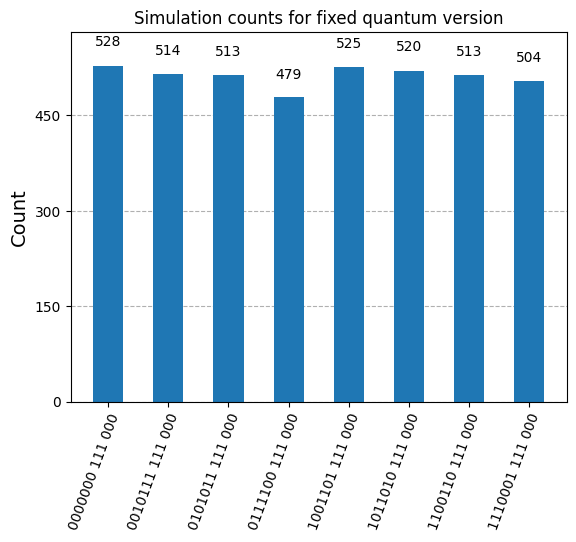

In [54]:
plot_histogram(classic_result.get_counts(), title='Simulation counts for fixed quantum version')

* Classic error correcting version down below

In [55]:
#   from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
#   from qiskit_aer import AerSimulator
#   
#   # Define registers
#   data = QuantumRegister(7, 'data')
#   ancilla_x0 = QuantumRegister(1, 'anc_x0')
#   ancilla_x1 = QuantumRegister(1, 'anc_x1')
#   ancilla_x2 = QuantumRegister(1, 'anc_x2')
#   ancilla_z0 = QuantumRegister(1, 'anc_z0')
#   ancilla_z1 = QuantumRegister(1, 'anc_z1')
#   ancilla_z2 = QuantumRegister(1, 'anc_z2')
#   syndrome_x = ClassicalRegister(3, 'sx')
#   syndrome_z = ClassicalRegister(3, 'sz')
#   logical_out = ClassicalRegister(7, 'out')  # Changed to 7 bits
#   
#   # Initialize circuit
#   circuit = QuantumCircuit(data, ancilla_x0, ancilla_x1, ancilla_x2, ancilla_z0, ancilla_z1, ancilla_z2, syndrome_x, syndrome_z, logical_out)
#   
#   # Step 1: Encode |0_L⟩
#   circuit.h(data[4])
#   circuit.h(data[5])
#   circuit.h(data[6])
#   circuit.cx(data[4], data[0])
#   circuit.cx(data[4], data[1])
#   circuit.cx(data[4], data[2])
#   circuit.cx(data[5], data[0])
#   circuit.cx(data[5], data[1])
#   circuit.cx(data[5], data[3])
#   circuit.cx(data[6], data[0])
#   circuit.cx(data[6], data[2])
#   circuit.cx(data[6], data[3])
#   circuit.barrier()
#   
#   # Step 2: Introduce X error on data[0]
#   circuit.x(data[0])
#   circuit.barrier()
#   
#   # Step 3: Measure X stabilizers
#   circuit.h(ancilla_x0[0])
#   circuit.cx(ancilla_x0[0], data[0])
#   circuit.cx(ancilla_x0[0], data[1])
#   circuit.cx(ancilla_x0[0], data[2])
#   circuit.cx(ancilla_x0[0], data[4])
#   circuit.h(ancilla_x0[0])
#   circuit.measure(ancilla_x0[0], syndrome_x[0])
#   circuit.barrier()
#   
#   circuit.h(ancilla_x1[0])
#   circuit.cx(ancilla_x1[0], data[0])
#   circuit.cx(ancilla_x1[0], data[1])
#   circuit.cx(ancilla_x1[0], data[3])
#   circuit.cx(ancilla_x1[0], data[5])
#   circuit.h(ancilla_x1[0])
#   circuit.measure(ancilla_x1[0], syndrome_x[1])
#   circuit.barrier()
#   
#   circuit.h(ancilla_x2[0])
#   circuit.cx(ancilla_x2[0], data[0])
#   circuit.cx(ancilla_x2[0], data[2])
#   circuit.cx(ancilla_x2[0], data[3])
#   circuit.cx(ancilla_x2[0], data[6])
#   circuit.h(ancilla_x2[0])
#   circuit.measure(ancilla_x2[0], syndrome_x[2])
#   circuit.barrier()
#   
#   # Step 4: Measure Z stabilizers
#   circuit.h(ancilla_z0[0])
#   circuit.cz(ancilla_z0[0], data[0])
#   circuit.cz(ancilla_z0[0], data[1])
#   circuit.cz(ancilla_z0[0], data[2])
#   circuit.cz(ancilla_z0[0], data[4])
#   circuit.h(ancilla_z0[0])
#   circuit.measure(ancilla_z0[0], syndrome_z[0])
#   circuit.barrier()
#   
#   circuit.h(ancilla_z1[0])
#   circuit.cz(ancilla_z1[0], data[0])
#   circuit.cz(ancilla_z1[0], data[1])
#   circuit.cz(ancilla_z1[0], data[3])
#   circuit.cz(ancilla_z1[0], data[5])
#   circuit.h(ancilla_z1[0])
#   circuit.measure(ancilla_z1[0], syndrome_z[1])
#   circuit.barrier()
#   
#   circuit.h(ancilla_z2[0])
#   circuit.cz(ancilla_z2[0], data[0])
#   circuit.cz(ancilla_z2[0], data[2])
#   circuit.cz(ancilla_z2[0], data[3])
#   circuit.cz(ancilla_z2[0], data[6])
#   circuit.h(ancilla_z2[0])
#   circuit.measure(ancilla_z2[0], syndrome_z[2])
#   circuit.barrier()
#   
#   # Step 5: Apply corrections
#   with circuit.if_test((syndrome_x, 0b111)): circuit.z(data[0])
#   with circuit.if_test((syndrome_x, 0b011)): circuit.z(data[1])
#   with circuit.if_test((syndrome_x, 0b101)): circuit.z(data[2])
#   with circuit.if_test((syndrome_x, 0b110)): circuit.z(data[3])
#   with circuit.if_test((syndrome_x, 0b001)): circuit.z(data[4])
#   with circuit.if_test((syndrome_x, 0b010)): circuit.z(data[5])
#   with circuit.if_test((syndrome_x, 0b100)): circuit.z(data[6])
#   
#   with circuit.if_test((syndrome_z, 0b111)): circuit.x(data[0])
#   with circuit.if_test((syndrome_z, 0b011)): circuit.x(data[1])
#   with circuit.if_test((syndrome_z, 0b101)): circuit.x(data[2])
#   with circuit.if_test((syndrome_z, 0b110)): circuit.x(data[3])
#   with circuit.if_test((syndrome_z, 0b001)): circuit.x(data[4])
#   with circuit.if_test((syndrome_z, 0b010)): circuit.x(data[5])
#   with circuit.if_test((syndrome_z, 0b100)): circuit.x(data[6])
#   circuit.barrier()
#   
#   # Step 6: Measure all data qubits to verify correction
#   for i in range(7):
#       circuit.measure(data[i], logical_out[i])
#   circuit.barrier()
#   
#   # Simulate
#   simulator = AerSimulator(method='statevector')
#   job = simulator.run(circuit, shots=4096)
#   result = job.result()
#   counts = result.get_counts()
#   print("Corrected simulation counts:", counts)

In [56]:
# Set up the preset pass manager with optimization level 0
preset_manager = generate_preset_pass_manager(backend)
preset_circuit = preset_manager.run(circuit)

# Run the circuit using the Sampler
job = Sampler(mode=backend).run([(preset_circuit)], shots=5000)
print(f"Job ID: {job.job_id()}, \n Job Status: {job.status()}")

Job ID: czc1mpj4spc000875fh0, 
 Job Status: QUEUED


In [57]:
# Get and display results
result = job.result()
pub_result = result[0]
print(f"Counts for the 'sx' output register: {pub_result.data.sx.get_counts()}")
print(f"Counts for the 'sz' output register: {pub_result.data.sz.get_counts()}")
print(f"Counts for the 'out' output register: {pub_result.data.out.get_counts()}")

Counts for the 'sx' output register: {'101': 671, '001': 709, '011': 715, '010': 566, '111': 701, '000': 538, '100': 541, '110': 559}
Counts for the 'sz' output register: {'001': 651, '011': 626, '000': 598, '010': 609, '100': 629, '110': 601, '111': 626, '101': 660}
Counts for the 'out' output register: {'0101101': 40, '1100010': 35, '0111111': 18, '0100110': 34, '0000010': 58, '1000110': 55, '1001011': 45, '1011010': 45, '0101100': 47, '0100011': 45, '1011011': 28, '0001001': 52, '1000100': 53, '1110010': 24, '1001001': 58, '1001101': 65, '0101011': 32, '0100000': 63, '0111001': 38, '0111101': 27, '0010011': 38, '0010110': 42, '0000100': 43, '1111111': 18, '1100100': 54, '0100100': 39, '1001100': 71, '0110000': 32, '0101001': 55, '1100000': 46, '0111100': 32, '0001011': 56, '0010000': 46, '1000000': 60, '0010001': 38, '1101010': 39, '0101111': 22, '0011100': 42, '1100001': 49, '0001101': 66, '0110011': 31, '0000101': 57, '0001000': 58, '0010100': 36, '0011000': 36, '0000001': 58, '10

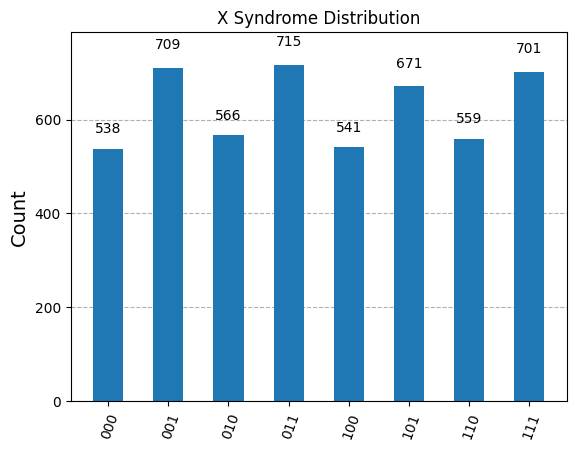

In [58]:

# Optional: Visualize the syndrome distributions
plot_histogram(pub_result.data.sx.get_counts(), title="X Syndrome Distribution")

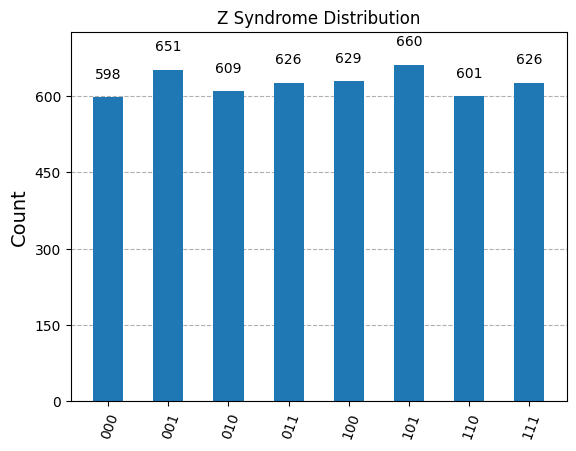

In [59]:
plot_histogram(pub_result.data.sz.get_counts(), title="Z Syndrome Distribution")
